In [65]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [66]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [67]:
#nltk.download()

# Loading Data and Pre-processing

In [68]:
my_columns = [
    'user_id', #1 user identifier
    'status_id', #1 status identifier
    #'created_at', #1 before or after debate
    #'screen_name', #1 profile screen name 
    'text', #1 tweet text
    'Y/N', #1 LABEL
    'display_text_width', #1 length
    'is_quote', #1 Whether the tweet is an original one or quoted one
    'favorite_count', #1
    'retweet_count',  #1
    #'quote_count', #1 All blank
    #'reply_count', #1 All blank
    'hashtags', #1
    'media_type', #1 contains just text or media (media = photo / video) contents: ‘photo’ / BLANK -> 'text'
    'mentions_screen_name', #1 Name
    #'quoted_source', #? TO BE DECIDED
    'followers_count', #1 info related to profile
    'friends_count', #1 info related to profile
    'listed_count', #1 info related to profile TO BE DECIDED
    'statuses_count', #1 info related to profile
    'favourites_count', #1 info related to profile
    'verified', #1 whether the profile is verified
]

In [165]:
file_name = 'proudboys-labelled.csv'
data = pd.read_csv(file_name, encoding='ISO-8859-1')
data = data[my_columns]
print(data.shape)

(2014, 17)


**Processing the Labels**

- Remove unlabled data
- Replace the original labels

In [166]:
# Remove the unlabeled data
data = data.dropna(subset=['Y/N'])
print(data.shape)

(2014, 17)


In [167]:
data['Supportive'] = data['Y/N'].str.contains('Y')
data['Offensive'] = data['Y/N'].str.contains('O')

In [185]:
N = data.shape[0]
N_SUPPORTIVE = data['Supportive'].sum(axis=0)
N_NON_SUPPORTIVE = N - N_SUPPORTIVE

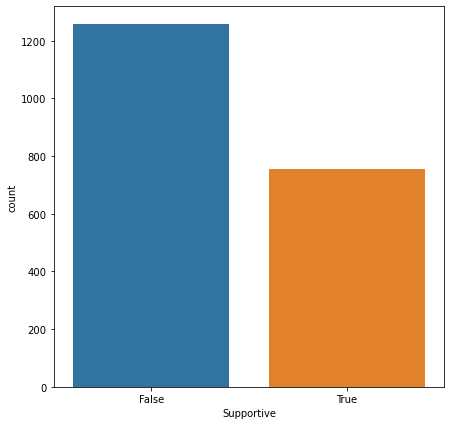

False    1257
True      757
Name: Supportive, dtype: int64
False    1712
True      302
Name: Offensive, dtype: int64


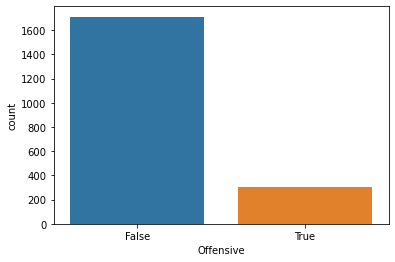

In [72]:
plt.figure(figsize=(7,7))
sns.countplot(data=data, x='Supportive')
plt.show()
print(data['Supportive'].value_counts())
sns.countplot(data=data, x='Offensive')
print(data['Offensive'].value_counts())
plt.show()

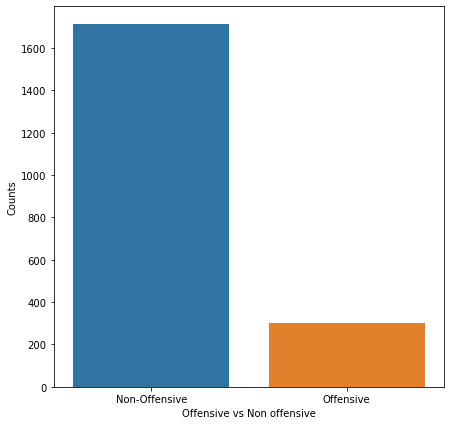

Non-Offensive    1712
Offensive         302
Name: Offensive, dtype: int64


In [232]:
#temp = data['Supportive'].map({False: 'Non-Supportive', True: 'Supportive'})
temp = data['Offensive'].map({False: 'Non-Offensive', True: 'Offensive'})
temp.head()
plt.figure(figsize=(7,7))
sns.countplot(x=temp)
plt.xlabel('Offensive vs Non offensive')
plt.ylabel('Counts')
plt.show()
print(temp.value_counts())

In [168]:
data['media_type'] = data['media_type'].fillna('plain_text')

   Supportive  media_type  percentage
1       False       photo    8.591885
3        True       photo    6.869221
0       False  plain_text   91.408115
2        True  plain_text   93.130779


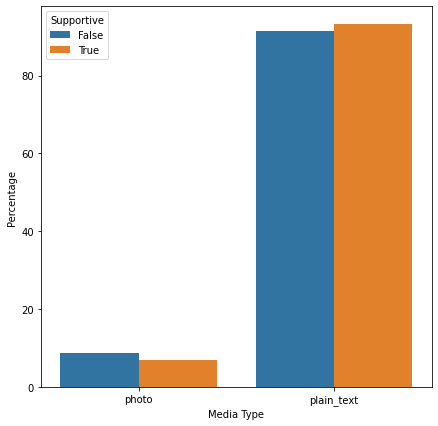

In [121]:
media_counts = (data.groupby(['Supportive'])['media_type']
             .value_counts(normalize=True)
             .rename('percentage')
             .mul(100)
             .reset_index()
             .sort_values('media_type'))

print(media_counts)
plt.figure(figsize=(7,7))
p = sns.barplot(data=media_counts, x='media_type', y='percentage', hue='Supportive')
p.set(xlabel='Media Type', ylabel='Percentage')
plt.show()

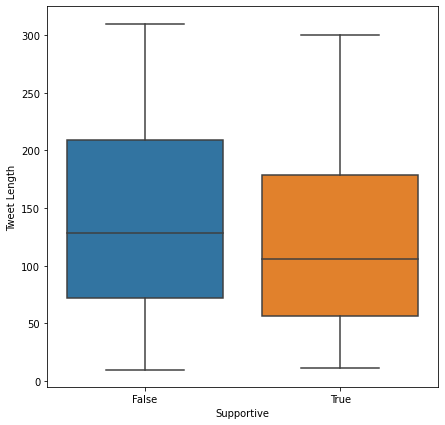

In [140]:
plt.figure(figsize=(7,7))
p = sns.boxplot(y='display_text_width',x='Supportive',data=data)
p.set(xlabel='Supportive', ylabel='Tweet Length')
plt.show()

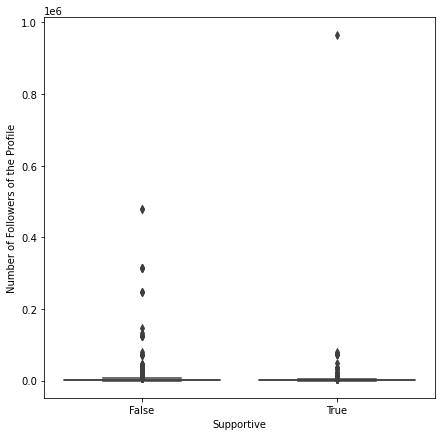

In [141]:
plt.figure(figsize=(7,7))
p = sns.boxplot(y='followers_count',x='Supportive',data=data)
p.set(xlabel='Supportive', ylabel='Number of Followers of the Profile')
plt.show()

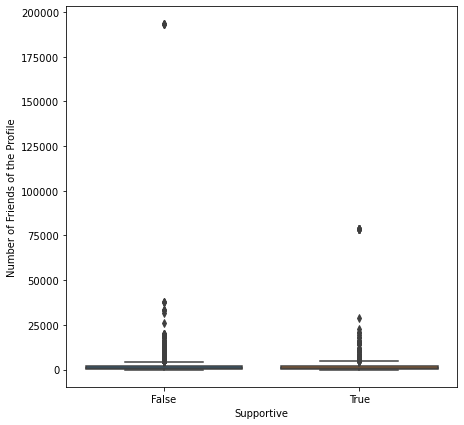

In [152]:
plt.figure(figsize=(7,7))
p = sns.boxplot(y='friends_count',x='Supportive',data=data)
p.set(xlabel='Supportive', ylabel='Number of Friends of the Profile')
plt.show()

In [156]:
#print(data['followers_count'].sort_values(ascending=False)[:50])

   Supportive  verified  percentage
0       False     False   97.692920
2        True     False   99.603699
1       False      True    2.307080
3        True      True    0.396301


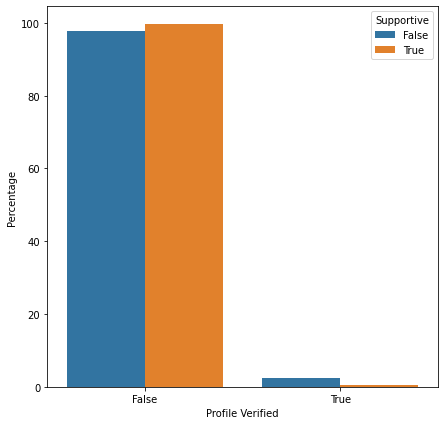

In [158]:
verified_profile = (data.groupby(['Supportive'])['verified']
             .value_counts(normalize=True)
             .rename('percentage')
             .mul(100)
             .reset_index()
             .sort_values('verified'))

print(verified_profile)
plt.figure(figsize=(7,7))
p = sns.barplot(data=verified_profile, x='verified', y='percentage', hue='Supportive')
p.set(xlabel='Profile Verified', ylabel='Percentage')
plt.show()

**Processing the Hashtags**

Replace:
    
- 'alllivesmatters' -> 'alllivesmatter'
- 'antifacist', 'antifascists' -> 'antifa'
- 'blacklivesmatter', 'blacklivesstillmatter', 'blacklivesmatter' -> 'blm'
- 'kag2020' -> 'kag'
- 'maga2020' -> 'maga'
- 'oregoncity' -> 'oregon'
- 'portlandprotestors' -> 'portlandprotesters'
- 'protests', 'protest2020', 'protests2020' -> 'protest'
- 'trump2020' -> 'trump'

In [169]:
data['hashtags_proc'] = data['hashtags'].str.lower()
data['hashtags_proc'] = data['hashtags_proc'].fillna('blank')

ht_replacements = {
    'alllivesmatters': 'alllivesmatter',
    'antifacist': 'antifa',
    'antifascists':'antifa',
    'blacklivesmatter': 'blm',
    'blacklivesstillmatter': 'blm',
    'blacklivematter': 'blm',
    'kag2020': 'kag',
    'maga2020': 'maga',
    'oregoncity': 'oregon',
    'portlandprotestors': 'portlandprotesters',
    'protests': 'protest',
    'protest2020': 'protest',
    'protests2020': 'protest',
    'trump2020': 'trump',
}

for k, v in ht_replacements.items():
    data['hashtags_proc'] = data['hashtags_proc'].str.replace(k, v, regex=True)

## Adding New Features

In [170]:
data['hashtags_count'] = data['hashtags'].apply(lambda x: len(x.split()) if pd.notnull(x) else 0)
data['hashtags_count'] = data['hashtags_count'].apply(lambda n: 3 if n > 2 else n)

data['hashtags_count'].head()

0    0
1    0
2    0
3    1
4    0
Name: hashtags_count, dtype: int64

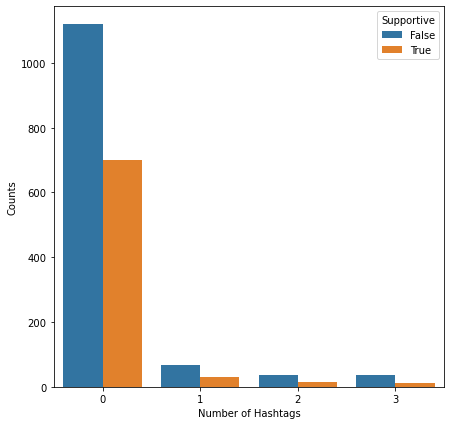

Supportive  hashtags_count
False       0                 1119
            1                   66
            3                   37
            2                   35
True        0                  700
            1                   31
            2                   15
            3                   11
Name: hashtags_count, dtype: int64


In [103]:
plt.figure(figsize=(7,7))
p = sns.countplot(x='hashtags_count', hue='Supportive', data=data)
p.set(xlabel='Number of Hashtags', ylabel='Counts')
plt.show()
print(data.groupby(['Supportive'])['hashtags_count'].value_counts())

   Supportive  hashtags_count  percentage
0       False               0   89.021480
4        True               0   92.470277
1       False               1    5.250597
5        True               1    4.095112
3       False               2    2.784407
6        True               2    1.981506
2       False               3    2.943516
7        True               3    1.453104


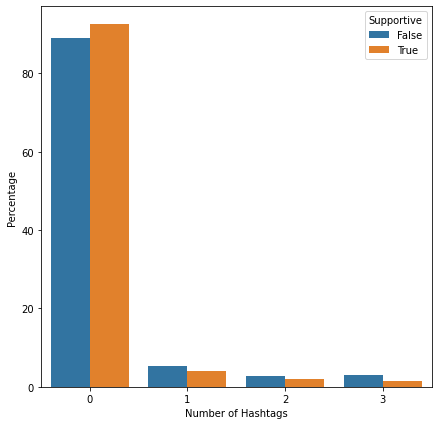

In [109]:
ht_counts = (data.groupby(['Supportive'])['hashtags_count']
             .value_counts(normalize=True)
             .rename('percentage')
             .mul(100)
             .reset_index()
             .sort_values('hashtags_count'))

print(ht_counts)
plt.figure(figsize=(7,7))
p = sns.barplot(data=ht_counts, x='hashtags_count', y='percentage', hue='Supportive')
p.set(xlabel='Number of Hashtags', ylabel='Percentage')
plt.show()

In [171]:
data['mention_count'] = data['mentions_screen_name'].apply(lambda x: len(x.split()) if pd.notnull(x) else 0)
data['mention_count'] = data['mention_count'].apply(lambda n: 4 if n > 3 else n)

data['mention_count'].head()

0    0
1    2
2    0
3    0
4    2
Name: mention_count, dtype: int64

   Supportive  mention_count  percentage
0       False              0   38.902148
6        True              0   23.778071
1       False              1   31.503580
5        True              1   44.782034
2       False              2   14.399364
7        True              2   21.796565
3       False              3    7.955449
8        True              3    5.416116
4       False              4    7.239459
9        True              4    4.227213


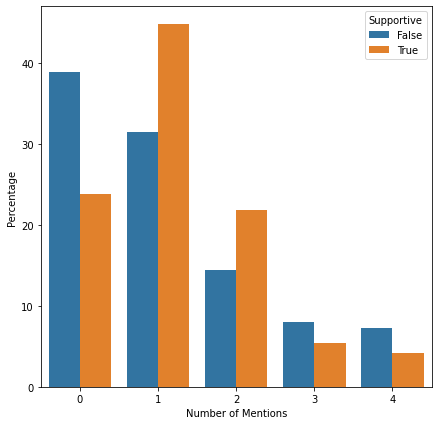

In [110]:
mention_counts = (data.groupby(['Supportive'])['mention_count']
             .value_counts(normalize=True)
             .rename('percentage')
             .mul(100)
             .reset_index()
             .sort_values('mention_count'))

print(mention_counts)
plt.figure(figsize=(7,7))
p = sns.barplot(data=mention_counts, x='mention_count', y='percentage', hue='Supportive')
p.set(xlabel='Number of Mentions', ylabel='Percentage')
plt.show()

In [172]:
data['exclamation_count'] = data['text'].str.count('\!')
data['exclamation_count'] = data['exclamation_count'].apply(lambda n: 3 if n > 2 else n)

data['question_count'] = data['text'].str.count('\?')
data['question_count'] = data['question_count'].apply(lambda n: 3 if n > 2 else n)

   Supportive  exclamation_count  percentage
0       False                  0   92.601432
4        True                  0   83.487450
1       False                  1    4.136834
5        True                  1    9.775429
2       False                  2    1.988862
6        True                  2    3.698811
3       False                  3    1.272872
7        True                  3    3.038309


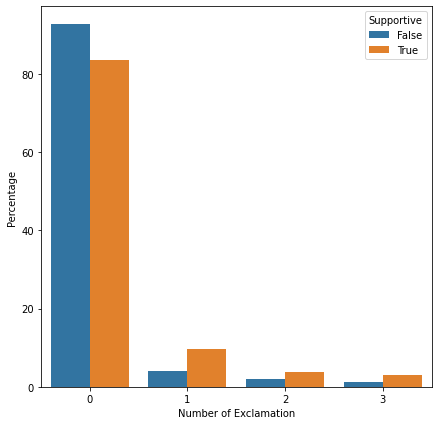

In [114]:
exclamation_counts = (data.groupby(['Supportive'])['exclamation_count']
             .value_counts(normalize=True)
             .rename('percentage')
             .mul(100)
             .reset_index()
             .sort_values('exclamation_count'))

print(exclamation_counts)
plt.figure(figsize=(7,7))
p = sns.barplot(data=exclamation_counts, x='exclamation_count', y='percentage', hue='Supportive')
p.set(xlabel='Number of Exclamation', ylabel='Percentage')
plt.show()

   Supportive  question_count  percentage
0       False               0   80.111376
4        True               0   84.015852
1       False               1   15.194909
5        True               1   10.435931
2       False               2    3.341289
6        True               2    3.830911
3       False               3    1.352426
7        True               3    1.717305


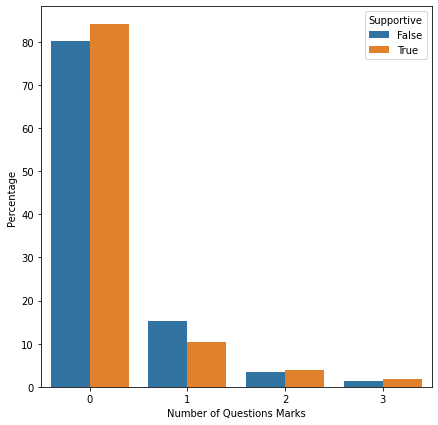

In [115]:
question_counts = (data.groupby(['Supportive'])['question_count']
             .value_counts(normalize=True)
             .rename('percentage')
             .mul(100)
             .reset_index()
             .sort_values('question_count'))

print(question_counts)
plt.figure(figsize=(7,7))
p = sns.barplot(data=question_counts, x='question_count', y='percentage', hue='Supportive')
p.set(xlabel='Number of Questions Marks', ylabel='Percentage')
plt.show()

In [99]:
#data.info()
#print(data['is_quote'].value_counts())
#print(data['media_type'].value_counts())
#print(data['verified'].value_counts())
#print(data['supportive'].value_counts())
#print(data['offensive'].value_counts())
#print(data['exclamation_count'].value_counts())
#print(data['question_count'].value_counts())
#print(data['hashtags_count'].value_counts())
#print(data['mention_count'].value_counts())
#print(data['followers_count'].value_counts().sort_index())

### Remove URLs, Hashtags, Mentions

In [173]:
data['text_proc'] = data['text'].str.lower()
data['text_proc'] = data['text_proc'].str.replace(r"http\S+", "", regex=True)
data['text_proc'] = data['text_proc'].str.replace(r"#\S+", "", regex=True)
data['text_proc'] = data['text_proc'].str.replace(r"@\S+", "", regex=True)

Pre-processing Steps:

    1. Lower case
    2. Word tokenize
    3. Removing numbers and punctuations
    4. Word stemming

In [174]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

for idx, row in data.iterrows():
    words = nltk.word_tokenize(row['text_proc'])
    words = [word for word in words if word.isalpha()]
    data.loc[idx, 'lem_text'] = ' '.join([lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))])
    words = [stemmer.stem(word) for word in words if word not in set(stopwords.words('english'))]
    data.loc[idx, 'text_proc'] = ' '.join(words)
    

data.head()

,user_id,status_id,text,Y/N,display_text_width,is_quote,favorite_count,retweet_count,hashtags,media_type,...,verified,Supportive,Offensive,hashtags_proc,hashtags_count,mention_count,exclamation_count,question_count,text_proc,lem_text
0,x382691414,x1297365508300447744,Proud boys are attacking Peaceful protesters i...,N,115,False,0,0,NaN,photo,...,False,False,False,blank,0,0,0,0,proud boy attack peac protest portland portlan...,proud boy attacking peaceful protester portlan...
1,x743936431,x1297365466306904066,"@Medde13 @MrAndyNgo I live in Portland, proud ...",N,189,False,0,0,NaN,plain_text,...,False,False,False,blank,0,2,0,0,live portland proud boy white supremacist hate...,live portland proud boy white supremacist hate...
2,x743936431,x1294749099976036353,Anyone else wondering why tRump and his deplor...,"N, O",175,False,9,0,NaN,plain_text,...,False,False,True,blank,0,0,0,1,anyon els wonder trump deplor base speak conde...,anyone else wondering trump deplorable base sp...
3,x375304364,x1297365456190406662,Not Antifa but the Right Wing Proud Boys. If y...,Y,126,True,0,0,CriticalThinking,plain_text,...,False,True,False,criticalthinking,1,0,0,0,antifa right wing proud boy think far left cau...,antifa right wing proud boy think far left cau...
4,x176941218,x1297365411533643776,@MARCIAN2003 @JoshuaPotash The police and the ...,N,42,False,0,0,NaN,plain_text,...,False,False,False,blank,0,2,0,0,polic proud boy,police proud boy


# Word Cloud

In [177]:
from PIL import Image
from wordcloud import WordCloud

mask = np.array(Image.open('cloud.png'))
wc_o = WordCloud(background_color='white', max_words=150)#, mask=mask)
wc_offensive = wc_o.generate(' '.join(data[data['Offensive'] == True]['lem_text']))

wc_no = WordCloud(background_color='white', max_words=200)#, mask=mask)
wc_nonoffensive = wc_no.generate(' '.join(data[data['Offensive'] == False]['lem_text']))

wc_s = WordCloud(background_color='white', max_words=150)#, mask=mask)
wc_supportive = wc_s.generate(' '.join(data[data['Supportive'] == True]['lem_text']))

wc_ns = WordCloud(background_color='white', max_words=150)#, mask=mask)
wc_nonsupportive = wc_ns.generate(' '.join(data[data['Supportive'] == False]['lem_text']))

In [161]:
#plt.figure(figsize=(10,7))
#plt.imshow(wc_offensive)
#plt.axis('off')

In [160]:
#plt.figure(figsize=(10,7))
#plt.imshow(wc_nonoffensive)

(-0.5, 399.5, 199.5, -0.5)

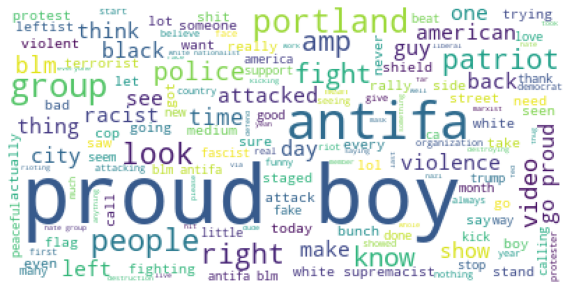

In [178]:
plt.figure(figsize=(10,7))
plt.imshow(wc_supportive)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

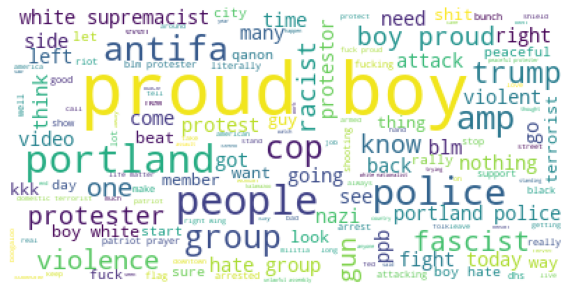

In [180]:
plt.figure(figsize=(10,7))
plt.imshow(wc_nonsupportive)
plt.axis('off')

**Removing Common Words**

In [201]:
from collections import Counter
MOST_COMMON = 20
counter_supportive = Counter(" ".join(data["text_proc"][data['Supportive'] == True]).split()).most_common(MOST_COMMON)
counter_nonsupportive = Counter(" ".join(data["text_proc"][data['Supportive'] == False]).split()).most_common(MOST_COMMON)

In [202]:
df1 = pd.DataFrame(counter_supportive, columns =['word', 'freq_supportive'])
df1 = df1.set_index('word')
df2 = pd.DataFrame(counter_nonsupportive, columns=['word', 'freq_non_supportive'])
df2 = df2.set_index('word')

common_supportive = pd.concat([df1,df2],axis=1)
#print(common_supportive)

remove_supportive = []
for idx, row in common_supportive.iterrows():
    if row[0] > 0 and row[1] > 0:
        remove_supportive.append(idx)

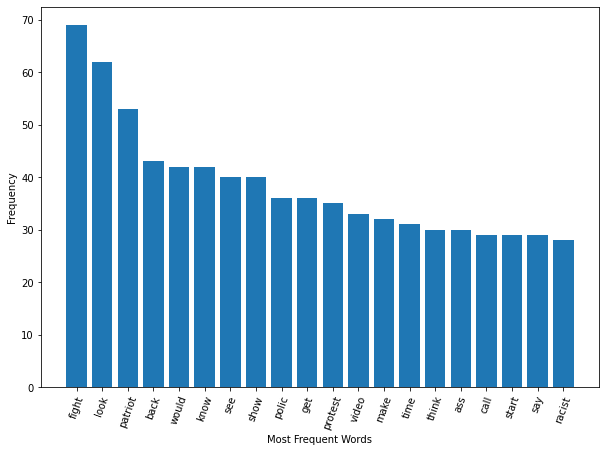

In [203]:
#counter_supportive.sort(key=lambda x: x[1], reverse=True)
plt.figure(figsize=(10,7))
plt.bar(range(len(counter_supportive)), [val[1] for val in counter_supportive], align='center')
plt.xlabel('Most Frequent Words')
plt.ylabel('Frequency')
plt.xticks(range(len(counter_supportive)), [val[0] for val in counter_supportive])
plt.xticks(rotation=70)
plt.show()

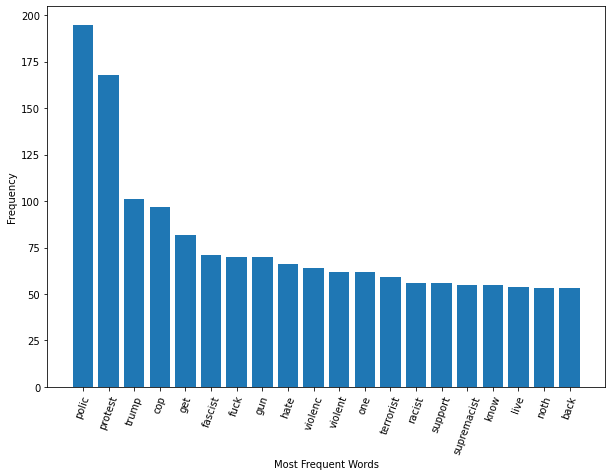

In [204]:
#counter_supportive.sort(key=lambda x: x[1], reverse=True)
plt.figure(figsize=(10,7))
plt.bar(range(len(counter_nonsupportive)), [val[1] for val in counter_nonsupportive], align='center')
plt.xlabel('Most Frequent Words')
plt.ylabel('Frequency')
plt.xticks(range(len(counter_nonsupportive)), [val[0] for val in counter_nonsupportive])
plt.xticks(rotation=70)
plt.show()

In [205]:
print(len(remove_supportive), remove_supportive)
print(common_supportive)
remove_supportive = set(remove_supportive)

6 ['back', 'know', 'polic', 'get', 'protest', 'racist']
             freq_supportive  freq_non_supportive
fight                   69.0                  NaN
look                    62.0                  NaN
patriot                 53.0                  NaN
back                    43.0                 53.0
would                   42.0                  NaN
know                    42.0                 55.0
see                     40.0                  NaN
show                    40.0                  NaN
polic                   36.0                195.0
get                     36.0                 82.0
protest                 35.0                168.0
video                   33.0                  NaN
make                    32.0                  NaN
time                    31.0                  NaN
think                   30.0                  NaN
ass                     30.0                  NaN
call                    29.0                  NaN
start                   29.0                

In [197]:
for idx, row in data.iterrows():
    words = nltk.word_tokenize(row['text_proc'])
    words = [word for word in words if word not in remove_supportive]
    data.loc[idx, 'lem_text'] = ' '.join([lemmatizer.lemmatize(word) for word in words])
    words = [stemmer.stem(word) for word in words]
    data.loc[idx, 'text_proc'] = ' '.join(words)

In [198]:
wc_s = WordCloud(background_color='white', max_words=150)#, mask=mask)
wc_supportive = wc_s.generate(' '.join(data[data['Supportive'] == True]['lem_text']))

wc_ns = WordCloud(background_color='white', max_words=150)#, mask=mask)
wc_nonsupportive = wc_ns.generate(' '.join(data[data['Supportive'] == False]['lem_text']))

(-0.5, 399.5, 199.5, -0.5)

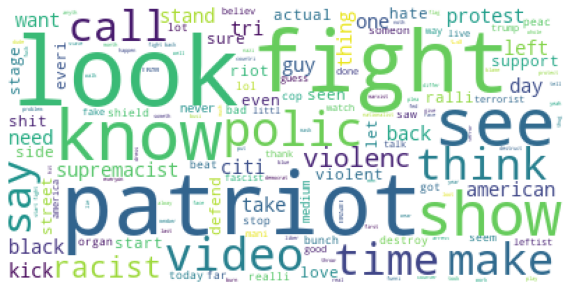

In [199]:
plt.figure(figsize=(10,7))
plt.imshow(wc_supportive)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

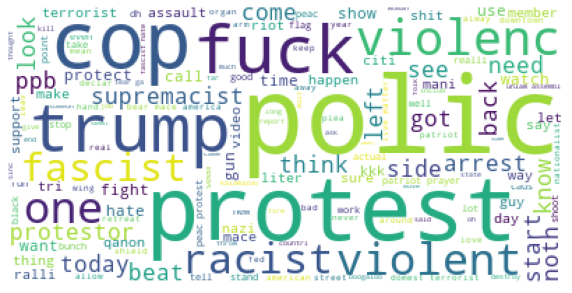

In [200]:
plt.figure(figsize=(10,7))
plt.imshow(wc_nonsupportive)
plt.axis('off')

# Linguistic Features

Bag of Words (**X1**)

In [216]:
# Bag of words
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=2000) # CountVectorizer(ngram_range=(2,2))
X1 = cv.fit_transform(data['text_proc']).toarray()
print(type(X1))
print(X1.shape)

<class 'numpy.ndarray'>
(2014, 2000)


In [214]:
vocab = cv.vocabulary_

count_values = X1.sum(axis=0)

for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    if ng_text.count(' ') == 0:
        print(ng_count, ng_text)

231 polic
203 protest
119 trump
118 get
111 cop
108 fight
104 look
99 patriot
97 know
96 back
91 violenc
87 would
87 one
85 hate
84 see
84 racist
84 fascist
81 violent
79 supremacist
78 show
78 fuck
77 terrorist
76 support
75 need
74 think
74 live
74 gun
73 start
70 time
68 today
68 side
66 video
66 call
65 left
64 want
63 noth
62 riot
62 peac
60 say
59 stand
59 protestor
59 make
59 beat
58 got
57 mace
57 let
55 thing
55 nazi
55 guy
54 tri
54 black
53 come
52 arrest
51 day
51 citi
49 watch
49 protect
48 shit
48 ralli
48 happen
48 also
47 member
46 mani
46 ass
45 sure
45 ppb
45 even
44 take
44 good
43 american
42 way
42 use
42 bunch
41 street
41 flag
41 actual
40 us
40 realli
40 organ
38 lot
38 blue
37 stop
37 love
37 assault
36 work
36 spray
36 never
36 everi
36 declar
35 shoot
35 seem
35 qanon
35 matter
35 kick
34 seen
34 kkk
34 far
33 vs
33 someon
33 shield
33 mean
32 well
32 prayer
32 liter
32 domest
32 destroy
31 year
31 real
31 bad
31 america
30 tell
29 saw
29 run
29 point
29 defe

1 yknow
1 yike
1 yesterday
1 yelp
1 yay
1 yassss
1 yall
1 wwe
1 wussi
1 wsbt
1 wrote
1 wronggon
1 written
1 writ
1 wreak
1 wray
1 wrap
1 woven
1 wound
1 wood
1 woke
1 wive
1 wiseman
1 wise
1 winner
1 wind
1 wimpi
1 wimp
1 wikipedia
1 wigger
1 wiener
1 whytf
1 whyte
1 whup
1 whther
1 whose
1 whizz
1 whit
1 whic
1 wgat
1 weight
1 wednesday
1 weather
1 weakl
1 watchout
1 watchig
1 wasteland
1 wasnt
1 washout
1 washington
1 warm
1 warfar
1 wail
1 wackjob
1 vr
1 voter
1 volunt
1 vladislav
1 vlad
1 virul
1 viru
1 virtuou
1 violen
1 twerp
1 tuesday
1 tucker
1 tuck
1 trick
1 tribal
1 tree
1 trauma
1 trap
1 transwoman
1 transit
1 transgend
1 tran
1 trait
1 tradit
1 trademark
1 trade
1 tenderloin
1 tendenc
1 tend
1 telegram
1 teargass
1 teacher
1 teach
1 taxpay
1 taunt
1 taught
1 superior
1 summon
1 summari
1 suit
1 suicid
1 suffer
1 suddenli
1 success
1 suburb
1 subtl
1 subjug
1 subject
1 sturgi
1 stun
1 stumbl
1 studi
1 stress
1 strengthen
1 strategi
1 strateg
1 strand
1 strait
1 straighten
1 

In [223]:
X1.shape

(2014, 2000)

N-gram (**X3**)

In [224]:
# N-Gram
from sklearn.feature_extraction.text import CountVectorizer
cv1 = CountVectorizer(ngram_range=(1,1))
cv2 = CountVectorizer(ngram_range=(2,2))
cv12 = CountVectorizer(ngram_range=(1,2))
X3_1 = cv1.fit_transform(data['text_proc']).toarray()
X3_2 = cv2.fit_transform(data['text_proc']).toarray()
X3_12 = cv12.fit_transform(data['text_proc']).toarray()

In [225]:
vocab = cv1.vocabulary_

count_values = X3_1.sum(axis=0)
temp = []
for i, (ng_count, ng_text) in enumerate(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)):
    temp.append((ng_text, ng_count))
    if i == 20:
        break
print(temp)

[('polic', 231), ('protest', 203), ('trump', 119), ('get', 118), ('cop', 111), ('fight', 108), ('look', 104), ('patriot', 99), ('know', 97), ('back', 96), ('violenc', 91), ('would', 87), ('one', 87), ('hate', 85), ('see', 84), ('racist', 84), ('fascist', 84), ('violent', 81), ('supremacist', 79), ('show', 78), ('fuck', 78)]


In [45]:
#for k, i in vocab.items():
#    print(k, i)
count_values[25155]

2054

Term Frequence - Inverse Document Frequency (**X2**)

In [218]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(max_features=2000)
X2 = cv.fit_transform(data['text_proc']).toarray()

In [219]:
X2.shape

(2014, 2000)

In [221]:
vocab = cv.vocabulary_

count_values = X2.sum(axis=0)
temp = []
for i, (ng_count, ng_text) in enumerate(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)):
    temp.append((ng_text, ng_count))
    if i == 20:
        break

In [222]:
temp

[('polic', 50.46904200500777),
 ('protest', 39.6170626400697),
 ('get', 29.304862538928877),
 ('fight', 29.23514462436978),
 ('cop', 29.044442610935043),
 ('trump', 28.204572061302656),
 ('look', 27.01889020856287),
 ('know', 26.595146482652005),
 ('patriot', 25.831858764028656),
 ('fuck', 24.941976906685117),
 ('back', 24.418713754725484),
 ('racist', 23.59370101343824),
 ('supremacist', 23.10815486198929),
 ('see', 22.66074435776404),
 ('need', 21.92744762825015),
 ('one', 21.73159084604405),
 ('terrorist', 21.551335354498523),
 ('would', 21.503628478459483),
 ('hate', 21.20662768730728),
 ('think', 21.036468965257527),
 ('show', 21.000268672692528)]

In [243]:
# use when different features need different preprocessing
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('feats', FeatureUnion([
        ('cvec', CountVectorizer()),
        ('tfic', TfidfVectorizer()),
    ])),
    ('nb', MultinomialNB())
])

pipe_parms = [{
    'feats__cvec__max_features': [1000, 2000],
    'feats__cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'feats__tfic__max_features': [1000, 2000],
    'feats__tfic__ngram_range': [(1,1), (1,2), (1,3)],    
}]

gs = GridSearchCV(pipeline, param_grid= pipe_parms, cv=5)
gs.fit(data.drop,)
# (OneHotEncoder(), ['Sex', 'Embarked']),
'''
column_trans = make_column_transformer(
    (CountVectorizer(max_features=2000), ['text_proc', 'hashtags_proc']),
    #(CountVectorizer(ngram_range=(1, 3), max_features=2000), ['text_proc']),
    (TfidfVectorizer(max_features=2000), ['text_proc', 'hashtags_proc']),
    remainder='passthrough')
X = data.drop('supportive', axis='columns')
column_trans.fit_transform(X)
'''

"\ncolumn_trans = make_column_transformer(\n    (CountVectorizer(max_features=2000), ['text_proc', 'hashtags_proc']),\n    #(CountVectorizer(ngram_range=(1, 3), max_features=2000), ['text_proc']),\n    (TfidfVectorizer(max_features=2000), ['text_proc', 'hashtags_proc']),\n    remainder='passthrough')\nX = data.drop('supportive', axis='columns')\ncolumn_trans.fit_transform(X)\n"

Word2Vec **NOTE**

In [ ]:
from gensim.models import Word2Vec
corpus = ' '.join(data['proc_text'])
#print(corpus)
model = Word2Vec(corpus, size=100, window=5, min_count=1, workers=4)
words = model.wv.vocab
print(len(words), len(data['proc_text']))

# To Do

WORD EMBEDDING **NOTE**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# To Do

Processing the Labels (**y**)

In [244]:
# Labels for Supportive / Non supportive
y = pd.get_dummies(data['supportive'])
y = y.iloc[:, 1].values
print(y[:6])

[0 0 0 1 0 0]


In [215]:
X_train.shape

(1611, 2000)

# Classifiers

Train Test Split (**X_train, y_train, X_test, y_test**)

In [246]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop('supportive', axis='columns'), y, test_size=0.20, random_state=0)

C:\Users\Fahim\Anaconda3\envs\social_media_mining\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

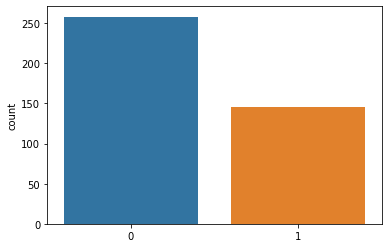

In [253]:
sns.countplot(y_test)

In [241]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

Naive Bayes

In [242]:
model_NB = MultinomialNB()
#.fit(X_train, y_train)

#y_pred = model_NB.predict(X_test)

Random Forest

In [211]:

model_RF = RandomForestClassifier(n_estimators=200, criterion='entropy').fit(X_train, y_train)
y_pred = model_RF.predict(X_test)

In [212]:
from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred)
print(confusion_m)

[[203  55]
 [ 64  81]]


In [213]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(report)
print(f'Accuracy: {accuracy*100}%, Precision: {precision*100}%, Recall: {recall*100}%, F1-score: {f1*100}%')

              precision    recall  f1-score   support

           0       0.76      0.79      0.77       258
           1       0.60      0.56      0.58       145

    accuracy                           0.70       403
   macro avg       0.68      0.67      0.67       403
weighted avg       0.70      0.70      0.70       403

Accuracy: 70.47146401985111%, Precision: 59.55882352941176%, Recall: 55.86206896551724%, F1-score: 57.65124555160141%


 **BEFORE removing URLs, Hashtags, Mentions; MOST_COMMON = 0**
 
 *BAG OF WORDS*

 
 Model           | Accuracy      |Precision     |Recall        |F1-score   
 ----------------|---------------|--------------|--------------|-----------
 Naive Bayes     | 0.76          | 0.65         | 0.72         | 0.68 
 Random Forest   | 0.73          | 0.62         | 0.66         | 0.64

 
 *TF - IDF*

 
 Model           | Accuracy      |Precision     |Recall        |F1-score   
 ----------------|---------------|--------------|--------------|-----------
 Naive Bayes     | 0.75          | 0.79         | 0.40         | 0.53 
 Random Forest   | 0.75          | 0.72         | 0.50         | 0.59
 
 
 **AFTER removing URLs, Hashtags, Mentions; MOST_COMMON = 0**
 
 *BAG OF WORDS*

 
 Model           | Accuracy      |Precision     |Recall        |F1-score   
 ----------------|---------------|--------------|--------------|-----------
 Naive Bayes     | 0.75          | 0.66         | 0.64         | 0.65 
 Random Forest   | 0.73          | 0.63         | 0.58         | 0.60

 
 *TF - IDF*

 
 Model           | Accuracy      |Precision     |Recall        |F1-score   
 ----------------|---------------|--------------|--------------|-----------
 Naive Bayes     | 0.75          | 0.66         | 0.64         | 0.65 
 Random Forest   | 0.70          | 0.60         | 0.56         | 0.58

In [ ]:
from emoji import UNICODE_EMOJI

def is_emoji(s):
    count = 0
    for emoji in UNICODE_EMOJI:
        count += s.count(emoji)
        if count > 1:
            return False
    return bool(count)

In [ ]:
def extract_emojis(s):
    return ''.join(c for c in s if c in UNICODE_EMOJI)

In [ ]:
sns.boxplot(x='supportive',y='followers_count',data=data)

In [ ]:
plt.figure(figsize=(12,4))
sns.countplot(x='followers_count',data=data)#,order=emp_length_order,hue='loan_status')
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
sns.distplot(data['followers_count'],kde=False,bins=40)
#plt.xlim(0,45000)